##### [Confusion Matrix]

In [2]:
import numpy as np
import pandas as pd

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

In [3]:
# =========================
# 1) 데이터 로딩 (PCA120 CSV)
# =========================
train_df = pd.read_csv("./Data/img_face_pca120_train.csv")
test_df  = pd.read_csv("./Data/img_face_pca120_test.csv")

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test  = test_df.iloc[:, :-1].values
y_test  = test_df.iloc[:, -1].values

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape,  y_test.shape)


Train: (2047, 120) (2047,)
Test : (512, 120) (512,)


In [5]:
# 라벨 순서 고정(혼동행렬 축 순서 일관성)
labels = np.unique(np.concatenate([y_train, y_test]))

# =========================
# 2) 모델 학습 (HistGradientBoosting)
# =========================
hgb = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_iter=500,
    max_depth=6,
    min_samples_leaf=20,
    l2_regularization=0.0,
    random_state=42
)

In [6]:

hgb.fit(X_train, y_train)

y_pred = hgb.predict(X_test)

In [7]:
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\n[Classification Report]")
print(classification_report(y_test, y_pred, labels=labels))


Accuracy: 0.482421875

[Classification Report]
              precision    recall  f1-score   support

       child       0.54      0.42      0.48        73
     elderly       0.56      0.60      0.58        73
      infant       0.78      0.82      0.80        73
 middle_aged       0.30      0.26      0.28        73
      senior       0.35      0.38      0.36        74
        teen       0.35      0.37      0.36        73
 young_adult       0.48      0.52      0.50        73

    accuracy                           0.48       512
   macro avg       0.48      0.48      0.48       512
weighted avg       0.48      0.48      0.48       512



[잘 맞는 클래스]
- infant 
    * recall : 0.82, precision : 0.78
    * 거의 독립적인 시각적 특징(얼굴 크기, 윤곽, 질감 등)
- elderly
    * recall : 0.6
    * 주름, 피부 등 비교적 명확 

[안 맞는 클래스]
- 가운데 연령대가 서로 완전히 섞임
    * teen ↔ young_adult
    * middle_aged ↔ senior
    * middle_aged ↔ young_adult
    * teen ↔ child 일부


[Confusion Matrix]
 [[31  3 12  3  7 12  5]
 [ 1 44  1  4 19  2  2]
 [ 5  1 60  2  1  1  3]
 [ 3  8  0 19 15 16 12]
 [ 4 17  0 17 28  5  3]
 [11  4  3  7  5 27 16]
 [ 2  1  1 12  5 14 38]]


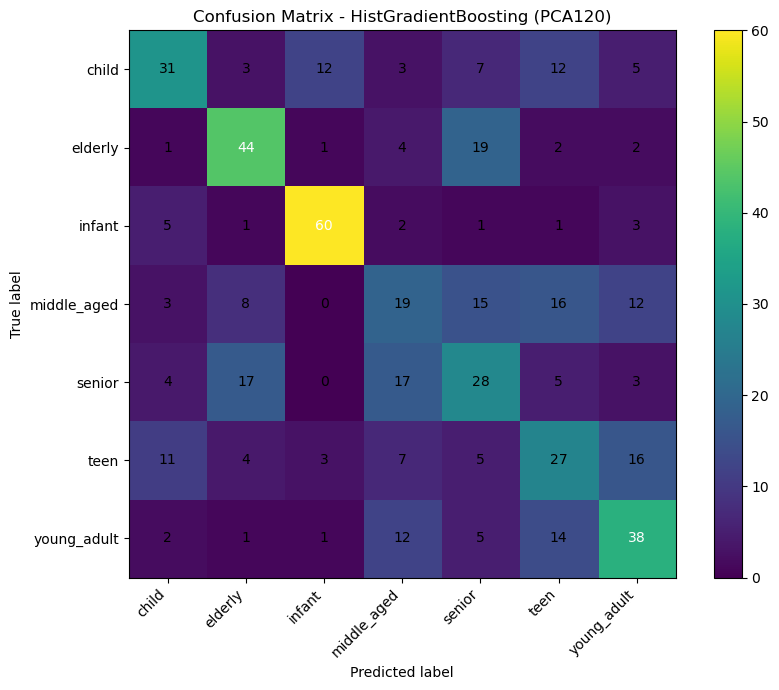

In [8]:
# =========================
# 3) Confusion Matrix (숫자 + 시각화)
# =========================
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\n[Confusion Matrix]\n", cm)

plt.figure(figsize=(9, 7))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - HistGradientBoosting (PCA120)")
plt.colorbar()
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)

# 칸에 숫자 표시
th = cm.max() * 0.6
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]),
                 ha="center", va="center",
                 color="white" if cm[i, j] > th else "black")

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

#### [연령대 레벨 제정의 ]
- young   : infant + child
- teen    : teen
- adult   : young_adult + middle_aged
- old     : senior + elderly

In [ ]:
## 모듈 로딩 
import numpy as np
import pandas as pd

from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
## 데이터 로딩 + 4level로 변환

## 데이터 로딩
train_df = pd.read_csv("./Data/img_face_pca120_train.csv")
test_df  = pd.read_csv("./Data/img_face_pca120_test.csv")

## 4레벨로 정의
label_map = {
    "infant": "young",
    "child": "young",
    "teen": "teen",
    "young_adult": "adult",
    "middle_aged": "adult",
    "senior": "old",
    "elderly": "old"
}

train_df["target"] = train_df["target"].map(label_map)
test_df["target"]  = test_df["target"].map(label_map)

# 매핑 실패 체크
assert train_df["target"].isna().sum() == 0
assert test_df["target"].isna().sum() == 0

X_train = train_df.iloc[:, :-1].values
y_train = train_df.iloc[:, -1].values

X_test  = test_df.iloc[:, :-1].values
y_test  = test_df.iloc[:, -1].values

labels = ["young", "teen", "adult", "old"]

print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (2047, 160) (2047,)
Test : (512, 160) (512,)


In [ ]:
## GridSearchCV 설정

hgb = HistGradientBoostingClassifier(random_state=42)

param_grid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_iter": [300, 600],
    "max_depth": [3, 5, 7],
    "min_samples_leaf": [10, 30],
    
    
    'max_leaf_nodes': [31, 63],
    'l2_regularization': [0.0, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid,
    scoring="f1_macro", ## 레벨의 통합하면서 불균형 데이터가 됨
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("\n[BEST PARAMS]")
print(grid.best_params_)
print("[BEST CV SCORE]", grid.best_score_)


Fitting 5 folds for each of 144 candidates, totalling 720 fits

[BEST PARAMS]
{'l2_regularization': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 300, 'max_leaf_nodes': 31, 'min_samples_leaf': 10}
[BEST CV SCORE] 0.5985575675314208


In [ ]:
# =========================
# 3) Best 모델로 Test 평가
# =========================
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("\n[Test Accuracy]", accuracy_score(y_test, y_pred))
print("\n[Classification Report]")
print(classification_report(y_test, y_pred, labels=labels))


[Test Accuracy] 0.66015625

[Classification Report]
              precision    recall  f1-score   support

       young       0.73      0.77      0.75       146
        teen       0.38      0.21      0.27        73
       adult       0.60      0.66      0.63       146
         old       0.72      0.78      0.75       147

    accuracy                           0.66       512
   macro avg       0.61      0.60      0.60       512
weighted avg       0.64      0.66      0.65       512



In [ ]:
import joblib
from pathlib import Path

# =========================
# 모델 저장 경로
# =========================
MODEL_DIR = Path("./Model")
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MODEL_PATH = MODEL_DIR / "ageModel_pca160.joblib"

# =========================
# 모델 저장
# =========================
joblib.dump(best_model, MODEL_PATH)

print(f"모델 저장 완료: {MODEL_PATH}")

모델 저장 완료: Model\ageModel_pca140.joblib


[재정의안]
- young   : infant + child
- teen    : teen
- adult   : young_adult + middle_aged
- old     : senior + elderly

“초기에는 7개 연령대로 세분화했으나,
Confusion Matrix 분석 결과 시각적으로 구분이 어려운
인접 연령대 간 혼동이 집중적으로 발생함을 확인했다.
이에 문제를 현실적으로 재정의하여 연령대를 통합했고,
그 결과 모델의 일반화 성능이 유의미하게 개선되었다.”